In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%pip install gurobipy 
import gurobipy as gp
from gurobipy import GRB 
from gurobipy import  *

from math import sqrt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
#import Pytorch
from sklearn.ensemble import *
from sklearn import tree
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

GLOBAL_RANDOM=42
N=10
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
/kaggle/input/fetal-health-classification/fetal_health.csv
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv
/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv
/kaggle/input/oil-spill-detection/oil_spill.csv
/kaggle/input/glass/glass.csv


In [3]:
#Load Data
all_train = np.genfromtxt('/kaggle/input/fashionmnist/fashion-mnist_train.csv', delimiter=',')
all_test = np.genfromtxt('/kaggle/input/fashionmnist/fashion-mnist_test.csv', delimiter=',')
train_data=all_train[1:,1:]
train_label=all_train[1:,0]
test_data=all_test[1:,1:]
test_label=all_test[1:,0]
Every_Dataset=[]
Every_Dataset.append([[train_data,train_label],[test_data,test_label],'fashion-mnist'])


In [4]:
all =pd.read_csv('/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv')#, delimiter=',')
#print(all.columns)
all = all.drop('loan_id', axis=1)

#print(all.iloc[1,:])
one_hot = pd.get_dummies(all[' education'],dtype=float)
all = all.drop(' education', axis=1)
all = all.join(one_hot)
one_hot = pd.get_dummies(all[' self_employed'],dtype=float)
all = all.drop(' self_employed', axis=1)
all = all.join(one_hot)
one_hot = pd.get_dummies(all[' loan_status'],dtype=float)
all = all.drop(' loan_status', axis=1)
all = all.join(one_hot)
print(all.iloc[1,:])
all=np.array(all)

train_data,train_label=all[1:int(.85*all.shape[0]),0:-1],all[1:int(.85*all.shape[0]),-1:].flatten()
test_data,test_label=all[1+int(.85*all.shape[0]):,0:-1],all[1+int(.85*all.shape[0]):,-1:].flatten()
Every_Dataset.append([[train_data,train_label],[test_data,test_label],'loan'])

 no_of_dependents                   0.0
 income_annum                 4100000.0
 loan_amount                 12200000.0
 loan_term                          8.0
 cibil_score                      417.0
 residential_assets_value     2700000.0
 commercial_assets_value      2200000.0
 luxury_assets_value          8800000.0
 bank_asset_value             3300000.0
 Graduate                           0.0
 Not Graduate                       1.0
 No                                 0.0
 Yes                                1.0
 Approved                           0.0
 Rejected                           1.0
Name: 1, dtype: float64


In [5]:
files=[['/kaggle/input/fetal-health-classification/fetal_health.csv','fetal_health'],
      #['/kaggle/input/glass/glass.csv','glass'],
      #['/kaggle/input/oil-spill-detection/oil_spill.csv','oil_spill'],
      ['/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv','Pulsar']  
      ]
for file in files:
    all =np.genfromtxt(file[0], delimiter=',')
    np.random.shuffle(all)
    train_data,train_label=all[1:int(.85*all.shape[0]),0:-1],all[1:int(.85*all.shape[0]),-1:].flatten()
    test_data,test_label=all[1+int(.85*all.shape[0]):,0:-1],all[1+int(.85*all.shape[0]):,-1:].flatten()
    d=np.isnan(train_label)
    t=np.isnan(test_label)
    
    train_label=train_label[np.logical_not(d)]
    train_data=train_data[np.logical_not(d)]
    test_label=test_label[np.logical_not(t)]
    test_data=test_data[np.logical_not(t)]
    
    
    
    
    Every_Dataset.append([[train_data,train_label],[test_data,test_label],file[1]])

In [6]:

for item in Every_Dataset:
    #print(len(item))
    #print(item)
    print(item[0][0].shape,item[0][1].shape,item[1][0].shape,item[1][1].shape,item[2])

(60000, 784) (60000,) (10000, 784) (10000,) fashion-mnist
(3627, 14) (3627,) (640, 14) (640,) loan
(1805, 21) (1805,) (319, 21) (319,) fetal_health
(15212, 8) (15212,) (2684, 8) (2684,) Pulsar


print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

In [63]:
#FNN
#Sklearn
results = np.array([["Iter","Time","Accuracy",'Loss',"Dataset"]])
n=2*N#5*N
for dataset in Every_Dataset:
    print(dataset[2])
    train_data=dataset[0][0]
    train_label=dataset[0][1]
    test_data=dataset[1][0]
    test_label=dataset[1][1]
    labels=np.unique(test_label)
    
    print(train_data.shape)
    print(test_data.shape)  
    labels=np.append(labels,np.unique(train_label), axis=0)
    labels=np.unique(labels)
      
    print(labels)
    for i in range(1, n):
        #FNN=MLPRegressor(random_state=GLOBAL_RANDOM, max_iter=i)
        FNN=MLPClassifier(random_state=GLOBAL_RANDOM, max_iter=i,shuffle=False,hidden_layer_sizes=(15,))
        start = time.time()
        FNN.fit(train_data, train_label)
        end = time.time()
        y_pred = FNN.predict(test_data)
        #print(np.unique(y_pred),np.unique(test_label))
        y_pred_log=FNN.predict_proba(test_data)
        #print(y_pred_log,np.unique(y_pred),np.unique(test_label))
        #print(np.unique(y_pred),)
        loss = log_loss(test_label, y_pred_log,)#labels=labels)
        acc  = accuracy_score(test_label, y_pred)
        # Calculate the time elapsed
        elapsed = end - start
        # Append the accuracy and time to the results array
       
        
        results = np.append(results, [[i,elapsed,acc,loss,dataset[2]]], axis=0)
    # save the dataframe as a csv file
#print(results.shape)
#print(results[1:,:])
df = pd.DataFrame(results[1:,:], columns=[str(x) for x in results[0,:]])
#print(df.head())
#DF = pd.DataFrame(results)
 
# save the dataframe as a csv file
df.to_csv("FNN_"+str(n)+".csv")


fashion-mnist
(60000, 784)
(10000, 784)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
loan
(3627, 14)
(640, 14)
[0. 1.]
fetal_health
(1805, 21)
(319, 21)
[1. 2. 3.]
Pulsar
(15212, 8)
(2684, 8)
[0. 1.]


In [64]:
#RF
#USE TREE COUNT instead of Epochs
#results = np.empty((0, 2))
results = np.array([["Iter","Time","Accuracy",'Loss',"Dataset"]])
n=2*N
for dataset in Every_Dataset:
    print(dataset[2])
    train_data=dataset[0][0]
    train_label=dataset[0][1]
    test_data=dataset[1][0]
    test_label=dataset[1][1]
    labels=np.unique(test_label)
    
    print(train_data.shape)
    print(test_data.shape)  
    labels=np.append(labels,np.unique(train_label), axis=0)
    labels=np.unique(labels)
      
    print(labels)
    for i in range(1, n):
        # Create a random forest classifier with i trees
        clf = RandomForestClassifier(n_estimators=i, random_state=GLOBAL_RANDOM)
        # Record the start time
        start = time.time()
        # Fit the classifier on the train data

        clf.fit(train_data, np.ravel(train_label))
        # Predict on the test data    
        # Record the end time
        end = time.time()
        y_pred = clf.predict(test_data)
        y_pred_log=clf.predict_proba(test_data)
        
        loss = log_loss(test_label, y_pred_log,)#labels=labels)
        acc  = accuracy_score(test_label, y_pred)
        # Calculate the time elapsed
        elapsed = end - start
        # Append the accuracy and time to the results array
                # Append the accuracy and time to the results array

        #print(dataset[2])
        results = np.append(results, [[i,elapsed,acc,loss,dataset[2]]], axis=0)
        # save the dataframe as a csv file

#print(results.shape)
#print(results[1:,:])
df = pd.DataFrame(results[1:,:], columns=[str(x) for x in results[0,:]])
#print(df.head())
#DF = pd.DataFrame(results)
 
# save the dataframe as a csv file
df.to_csv("RF_"+str(n)+".csv")


fashion-mnist
(60000, 784)
(10000, 784)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
loan
(3627, 14)
(640, 14)
[0. 1.]
fetal_health
(1805, 21)
(319, 21)
[1. 2. 3.]
Pulsar
(15212, 8)
(2684, 8)
[0. 1.]


In [65]:
#GBT
#USE TREE COUNT instead of Epochs
#results = np.empty((0, 2))
results = np.array([["Iter","Time","Accuracy",'Loss',"Dataset"]])
n=N
for dataset in Every_Dataset:
    print(dataset[2])
    train_data=dataset[0][0]
    train_label=dataset[0][1]
    test_data=dataset[1][0]
    test_label=dataset[1][1]
    labels=np.unique(test_label)
    
    print(train_data.shape)
    print(test_data.shape)  
    labels=np.append(labels,np.unique(train_label), axis=0)
    labels=np.unique(labels)
      
    print(labels)
    for i in range(1,n):
        # Create a random forest classifier with i trees
        GBT = HistGradientBoostingClassifier(max_iter=i, random_state=GLOBAL_RANDOM)
        # Record the start time
        start = time.time()
        # Fit the classifier on the train data
        GBT.fit(train_data, train_label)
        # Predict on the test data

        # Record the end time
        end = time.time()
        y_pred = GBT.predict(test_data)
        y_pred_log=GBT.predict_proba(test_data)
        
        loss = log_loss(test_label, y_pred_log,)#labels=labels)
        acc  = accuracy_score(test_label, y_pred)
        # Calculate the time elapsed
        elapsed = end - start
        # Append the accuracy and time to the results array
                # Append the accuracy and time to the results array

        #print(dataset[2])
        results = np.append(results, [[i,elapsed,acc,loss,dataset[2]]], axis=0)

# Print the results array
#print(results.shape)
#print(results[1:,:])
df = pd.DataFrame(results[1:,:], columns=[str(x) for x in results[0,:]])
#print(df.head())
#DF = pd.DataFrame(results)
 
# save the dataframe as a csv file
df.to_csv("GBT_"+str(n)+".csv")


fashion-mnist
(60000, 784)
(10000, 784)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
loan
(3627, 14)
(640, 14)
[0. 1.]
fetal_health
(1805, 21)
(319, 21)
[1. 2. 3.]
Pulsar
(15212, 8)
(2684, 8)
[0. 1.]


In [10]:
#BAY


In [11]:
#SVM

In [12]:
#REG

In [13]:
#CNN

In [14]:
#RNN

In [67]:
#N=5
files=['/kaggle/working/FNN_'+str(2*N)+'.csv',
       '/kaggle/working/RF_'+str(2*N)+'.csv',
       '/kaggle/working/GBT_'+str(N)+'.csv'
      ]
all_epochs=np.array([[0,0,0,0]])
all_epochs_time=np.array([[0,0,0,0]])
names=[]
c=0
for file in files:
    data=pd.read_csv(file)
    #print(data)
    #data=data.iloc[:,1:]
    nam=file
    for i in range(1,3*N):
        c+=1
        #print(df)
       #np.array(data['Accuracy'])
        #print(all_epochs.shape)
        try:
            df=data.loc[data['Iter'] == i]
            #names.append(str(file[-10:-7]+'_'+str(i)))
            #print(df)
            #print(i,'time',all_epochs_time.shape)
            #X = np.insert(X
            #a=np.append(np.array(df['Accuracy']),values=file[-10:-7]+'_'+str(i), axis=0)
            all_epochs=np.vstack((all_epochs, np.array(df['Accuracy'])))
            all_epochs_time=np.vstack((all_epochs_time, np.array(df['Time'])))
            names.append(str(file[-10:-7]+'_'+str(i)))
            #print('time',all_epochs_time.shape)
            #print(i,'time',all_epochs_time.shape)
            #print(df['Accuracy'])
            #print(np.array(df['Time']))
            #print(np.array(df['Accuracy']))
            #print(np.array(df['Dataset']))
            #all_epochs=np.append(all_epochs,values=np.array(data['Accuracy']), axis=1)
        except Exception as e:
            print(c,e)
            print('time',all_epochs_time.shape)

            break

#all_epochs=all_epochs.transpose()
#names=np.array(names)
all_epochs=np.delete(all_epochs, 0, axis=0)
all_epochs_time=np.delete(all_epochs_time, 0, axis=0)

#print('acc',all_epochs)

print('time',all_epochs_time.shape)
covar_matrix=np.cov(all_epochs)
mean_acc=np.array([x.mean() for x in all_epochs]) #for a given model and epoch, over all datasets
mean_var=np.array([x.var() for x in all_epochs]) #for a given model and epoch, over all datasets
mean_time=np.array([x.mean() for x in all_epochs_time])
#print(covar_matrix.shape)
#print(covar_matrix)
#print(mean_acc.shape)
#print('mean time',mean_time)
#print('part',np.sort(mean_time)[-2])
MAX_TIME=np.sort(mean_time)[-2]#(mean_time.max()+np.sort(mean_time)[-2])/2
print('max',MAX_TIME)
norm_mean_time=np.array([x/MAX_TIME for x in mean_time])
#print(all_epochs[0])
print(norm_mean_time)
print(norm_mean_time.shape)
print(names)
print(len(names))
mean_shift=mean_acc
mean_shift=np.array(list(mean_shift[-1:]) + list(mean_shift[:-1]))#np.array(list(mean_acc).rotate(1))    
print(mean_shift)

20 all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 0
time (20, 4)
40 all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 0
time (39, 4)
50 all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 0
time (48, 4)
time (47, 4)
max 6.327643930912018
[0.04816278 0.11515371 0.11743857 0.16897738 0.19831292 0.24824445
 0.28333335 0.38519263 0.39555938 0.43581395 0.49990368 0.49118344
 0.55168341 0.64794191 0.59467786 0.65484657 0.68297292 0.76195591
 0.79307706 0.05623925 0.11100874 0.15632685 0.20409466 0.24907725
 0.30719609 0.35828697 0.40799882 0.45654308 0.50199001 0.55749605
 0.60023002 0.64912803 0.69689687 0.75180792 0.8011595

In [80]:
#Create all constraints for only one epoch per model
import itertools

def gen_comb():
    all_const=[]#list(itertools.combinations([x for x in range(0,N-1)], r=2))]
    #for i in range(0,3):  #number of models
    for i in range(0,3):  #number of models
        if i==0:
            #perms=list(itertools.permutations([x for x in range(0,5*N)], r=2))
            perms=list(itertools.combinations([x for x in range(1,2*N)], r=2))

            all_const.append(perms)
        if i==1:
            perms=list(itertools.combinations([x for x in range(2*N,4*N-1)], r=2))
            all_const.append(perms)
        if i==2:
            perms=list(itertools.combinations([x for x in range(4*N-1,5*N-1)], r=2))
            all_const.append(perms)
    #print(np.array(all_const).shape)
    #print(all_const)
    return(all_const)
a=gen_comb()
print(len(a))
for elm in a:
    print(len(elm))
print(a[2])

3
171
171
45
[(39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (39, 46), (39, 47), (39, 48), (40, 41), (40, 42), (40, 43), (40, 44), (40, 45), (40, 46), (40, 47), (40, 48), (41, 42), (41, 43), (41, 44), (41, 45), (41, 46), (41, 47), (41, 48), (42, 43), (42, 44), (42, 45), (42, 46), (42, 47), (42, 48), (43, 44), (43, 45), (43, 46), (43, 47), (43, 48), (44, 45), (44, 46), (44, 47), (44, 48), (45, 46), (45, 47), (45, 48), (46, 47), (46, 48), (47, 48)]


In [18]:
#Put time porportion constraints on each epoch

In [19]:
def epoch_exlusiviy(m):
    for model in gen_comb():
        for epoch in model:
            #print((epoch[0]-1,epoch[1]-1))
            m.addConstr(x[epoch[0]-1]*x[epoch[1]-1] ==0,"exlusive"+str(epoch[0])+str(epoch[1]))

def epoch_bounds(m):
    for i in range(0,2*N-1): #NN
        if i==0:
            #m.addConstr(0<=(x[0]*(x[0]-,'0l')
            m.addConstr(x[0]*(x[0]-norm_mean_time[1])<=0,'0u')
            print('lower:',0,' x ','upper:',norm_mean_time[1])
        else:
            m.addConstr(x[i]*(x[i]-(norm_mean_time[i-1]+epsilon))>=0,str(i)+'l')
            m.addConstr(x[i]*(x[i]-norm_mean_time[i])<=0,str(i)+'u')
            print('lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])

    for i in range(2*N-1,4*N-2): #NN
        if i==2*N-1:
            #m.addConstr(0<=(x[0]*(x[0]-,'0l')
            m.addConstr(x[2*N-1]*(x[2*N-1]-norm_mean_time[2*N])<=0,'0u')
            print('lower:',0,' x ','upper:',norm_mean_time[2*N])
        else:
            m.addConstr(x[i]*(x[i]-(norm_mean_time[i-1]+epsilon))>=0,str(i)+'l')
            m.addConstr(x[i]*(x[i]-norm_mean_time[i])<=0,str(i)+'u')
            print('lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])
    
    for i in range(4*N-2,5N-3): #NN
        if i==4*N-2:
            #m.addConstr(0<=(x[0]*(x[0]-,'0l')
            m.addConstr(x[4*N-2]*(x[4*N-2]-norm_mean_time[4*N-1])<=0,'0u')
            print('lower:',0,' x ','upper:',norm_mean_time[4*N-1])
        else:
            m.addConstr(x[i]*(x[i]-(norm_mean_time[i-1]+epsilon))>=0,str(i)+'l')
            m.addConstr(x[i]*(x[i]-norm_mean_time[i])<=0,str(i)+'u')
            print('lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])
    

In [112]:
def XOR_test(m):
    m.addConstr(e1.sum() == 1, 'exclusive_sum_1')
    m.addConstr(e2.sum() == 1, 'exclusive_sum_2')
    m.addConstr(e3.sum() == 1, 'exclusive_sum_3')
    for i in range (0,2*N-1):
        m.addConstr(x[i]<=e1[i],'exclusive_var_'+str((1,i))) #x<=0 or x<=1
    
        #m.addConstr(x[i]*e1[i]<=norm_mean_time[i]*e1[i])
    m.addConstr(x[0]<=norm_mean_time[0]*e1[0])#*e1[0]
    for i in range (1,2*N-1):
        m.addConstr(x[i]>=norm_mean_time[i-1]*e1[i])#*e1[i]
        m.addConstr(x[i]<=norm_mean_time[i]*e1[i])#*e1[i]
        print('Epoch ',i+1, 'lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])
    
   ##################################
    for i in range (2*N-1,4*N-2):
        m.addConstr(x[i]<=e2[i-(2*N-1)],'exclusive_var_'+str((2,i)))
        
    m.addConstr(x[2*N-1]<=norm_mean_time[2*N-1]*e2[0]) #*e2[0]
    #print('Epoch ',i+1, ' x ','upper:',norm_mean_time[i])
    for i in range (2*N,4*N-2):
        print('Epoch ',i+1, 'lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])

        m.addConstr(x[i]>=norm_mean_time[i-1]*e2[i-2*N]) #*e2[i-9]
        m.addConstr(x[i]<=norm_mean_time[i]*e2[i-2*N])#*e2[i-9]
    ##################################
    for i in range (4*N-2,5*N-3):
        m.addConstr(x[i]<=e3[i-(4*N-2)],'exclusive_var_'+str((3,i)))
        
    m.addConstr(x[4*N-2]<=norm_mean_time[4*N-2]*e3[0]) #*e2[0]
    #print('Epoch ',i+1, ' x ','upper:',norm_mean_time[i])
    for i in range (4*N-1,5*N-3):
        print('Epoch ',i+1, 'lower:',norm_mean_time[i-1], ' x ','upper:',norm_mean_time[i])

        m.addConstr(x[i]>=norm_mean_time[i-1]*e3[i-(4*N-1)]) #*e2[i-9]
        m.addConstr(x[i]<=norm_mean_time[i]*e3[i-(4*N-1)])#*e2[i-9]

        

In [118]:
#https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/portfolio_selection_optimization/portfolio_selection_optimization.ipynb#scrollTo=qPMdJ5Vdzlxp

with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 0)
    env.start()
    with gp.Model(env=env) as m:
            # Create an empty model
        m = gp.Model('portfolio')
        print(len(covar_matrix[0]))

        # Add matrix variable for the epochs
        x = m.addMVar(len(covar_matrix[0]))
        z = m.addMVar(len(covar_matrix[0]))

        #Exclusive
        e1 = m.addMVar(19, vtype=GRB.BINARY) #XOR NN
        e2 = m.addMVar(19, vtype=GRB.BINARY) #XOR RF
        e3 = m.addMVar(9, vtype=GRB.BINARY)
        portfolio_risk = x @ covar_matrix @ x
        #portfolio_risk = gp.quicksum([z[i] * covar_matrix[i] * x[i] for i in range(len(covar_matrix[0]))])
        m.setObjective(portfolio_risk, GRB.MINIMIZE)


        # Fix budget with a constraint
        #for i in range(len(covar_matrix[0])):
            #m.addConstrs(z[i] == discount(x[i]),"z_def_"+str(i))
            #m.addConstr((z[i]+1)*(1-x[i]) == 1,"z_def_"+str(i))

        #m.addConstr(x.sum() >=.5, 'Lbudget')
        #m.addConstr(x.sum() <=.6, 'Ubudget')
        m.addConstr(x.sum() <=1, 'Ubudget')
        epsilon=0.01
        #or model in all_const: #try to add exclusivisty constrains
         #   for i in range(len(x)):
          #      m.addGenConstrIndicator(x[i], 1, t[i] >=  + epsilon, name=f"lower_bound_{i}")
        #for i in range(0,18):
            #m.addConstr(x[i]<=.6)
        XOR_test(m)
        #m.setParam("Presolve", 0)
        #make epochs exclusive
        #epoch_exlusiviy(m)
        #Add investment bounds on each epoch
        #epoch_bounds(m)

        # Verify model formulation
        m.write('portfolio_selection_optimization.lp')

        # Optimize model to find the minimum risk portfolio
        m.optimize()

47
Epoch  2 lower: 0.04816278266265181  x  upper: 0.11515370503699553
Epoch  3 lower: 0.11515370503699553  x  upper: 0.11743857156928861
Epoch  4 lower: 0.11743857156928861  x  upper: 0.1689773824852276
Epoch  5 lower: 0.1689773824852276  x  upper: 0.19831292030974795
Epoch  6 lower: 0.19831292030974795  x  upper: 0.24824445353363855
Epoch  7 lower: 0.24824445353363855  x  upper: 0.283333350131837
Epoch  8 lower: 0.283333350131837  x  upper: 0.3851926345801996
Epoch  9 lower: 0.3851926345801996  x  upper: 0.39555937740877
Epoch  10 lower: 0.39555937740877  x  upper: 0.43581394576420024
Epoch  11 lower: 0.43581394576420024  x  upper: 0.4999036786358706
Epoch  12 lower: 0.4999036786358706  x  upper: 0.49118343722046093
Epoch  13 lower: 0.49118343722046093  x  upper: 0.5516834083537238
Epoch  14 lower: 0.5516834083537238  x  upper: 0.6479419052606028
Epoch  15 lower: 0.6479419052606028  x  upper: 0.5946778628976275
Epoch  16 lower: 0.5946778628976275  x  upper: 0.6548465706782584
Epoch  1

In [119]:
def calc_return(e1,e2,x):
    returns=0
    for i in range(0,N*2-1):
        if e1[i]==1 and x[i]!=0:
            returns+=mean_acc[i-1]+x[i]*(mean_acc[i]-mean_acc[i-1])
            #print(returns)
    for i in range(N*2-1,4*N-2):
        if e2[i-N*2-1]==1 and x[i]!=0:
            returns+=mean_acc[i-1]+x[i]*(mean_acc[i]-mean_acc[i-1])
            #print(mean_acc[i-1],mean_acc[i]-mean_acc[i-1])
    for i in range(4*N-2,5*N-3):
        if e2[i-4*N-2]==1 and x[i]!=0:
            returns+=mean_acc[i-1]+x[i]*(mean_acc[i]-mean_acc[i-1])

    return returns
            

In [120]:
minrisk_volatility = sqrt(m.ObjVal)
#minrisk_return = mean_acc @ x.X
#minrisk_return = np.array(mean_acc[0:9]) @ e1 + np.array(mean_acc[9:]) @ e2
#minrisk_return = mean_acc[0:9] @ e1.X + mean_acc[9:] @ e2.X
minrisk_return = calc_return(e1.X,e2.X,x.X)

#minrisk_return = aa(e1,e2,x,x1,x2)
#print(e1.X)
#print(e2.X)
#print(x.X)
#print(mean_acc)
print(minrisk_return)
#print(x.X)
print(names)
#print(norm_mean_time)
#minrisk_return= mean_acc @ np.array([1 if x > 0 else 0 for x in x.X])
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=names + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

0
['FNN_1', 'FNN_2', 'FNN_3', 'FNN_4', 'FNN_5', 'FNN_6', 'FNN_7', 'FNN_8', 'FNN_9', 'FNN_10', 'FNN_11', 'FNN_12', 'FNN_13', 'FNN_14', 'FNN_15', 'FNN_16', 'FNN_17', 'FNN_18', 'FNN_19', '/RF_1', '/RF_2', '/RF_3', '/RF_4', '/RF_5', '/RF_6', '/RF_7', '/RF_8', '/RF_9', '/RF_10', '/RF_11', '/RF_12', '/RF_13', '/RF_14', '/RF_15', '/RF_16', '/RF_17', '/RF_18', '/RF_19', 'GBT_1', 'GBT_2', 'GBT_3', 'GBT_4', 'GBT_5', 'GBT_6', 'GBT_7', 'GBT_8', 'GBT_9']


,Minimum Risk Portfolio
FNN_1,0.0
FNN_2,0.0
FNN_3,0.0
FNN_4,0.0
FNN_5,0.0
FNN_6,0.0
FNN_7,0.0
FNN_8,0.0
FNN_9,0.0
FNN_10,0.0


In [51]:
def aa(e1,e2,x1,x2):
    u1=mean_acc[0:9] @ e1
    u2=mean_acc[9:] @ e2
    l1=mean_shift[0:9] @ e1
    l2=mean_shift[9:] @ e2
    
    #diff1 = np.full(9,u1-l1) # create the array
    #diff2 = np.full(u2-l2,9)
    a1=u1-l1
    a2=u2-l2
    s1 = gp.quicksum([a1*x1[i] for i in range(0,9)])
    s2 = gp.quicksum([a2*x2[i] for i in range(0,9)])
    
    #print(s1)
    returns=l1+l2+s1+s2
    print(returns)
    return returns

In [116]:
#portfolio_return = mean_acc @ x
print(mean_acc[0:9])
portfolio_return = mean_acc[0:2*N-1] @ e1 + mean_acc[2*N-1:4*N-2] @ e2 + mean_acc[4*N-2:] @ e3
#portfolio_return = aa(e1,e2,x1,x2)
#portfolio_return = mean_acc @ var.setAttr([1 if x > 0 else 0 for x in x.X])
target = m.addConstr(portfolio_return <= minrisk_return+.05, 'target')
target = m.addConstr(portfolio_return >= minrisk_return-.05, 'target')
#target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
feasible=[]
infeasible=[]
frontier = np.empty((2,0))
print (mean_acc.max())
for r in np.linspace(mean_acc.min(),mean_acc.max(), 50):#mean_acc.max(), 25): #1.1, 25):#mean_acc.max(), 25):
    #print(r,'##############')
    target.rhs = r
    #m.addConstr(portfolio_return == r, 'target')
    m.optimize()
    if m.status == GRB.OPTIMAL:
        
        frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)
        feasible.append(r)
    else:
        infeasible.append(r)
print('feas',feasible)
print('infeas',infeasible)


[0.39199038 0.46569128 0.50127329 0.622386   0.63579527 0.64547965
 0.58662536 0.60292392 0.62816717]
0.950570056272162
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 145 rows, 141 columns and 511 nonzeros
Model fingerprint: 0xd29ba582
Model has 1128 quadratic objective terms
Variable types: 94 continuous, 47 integer (47 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-05, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+00]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R143 by 1.860761196

Presolve removed 0 rows and 95 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00

(2, 0)
[]


ValueError: zero-size array to reduction operation minimum which has no identity

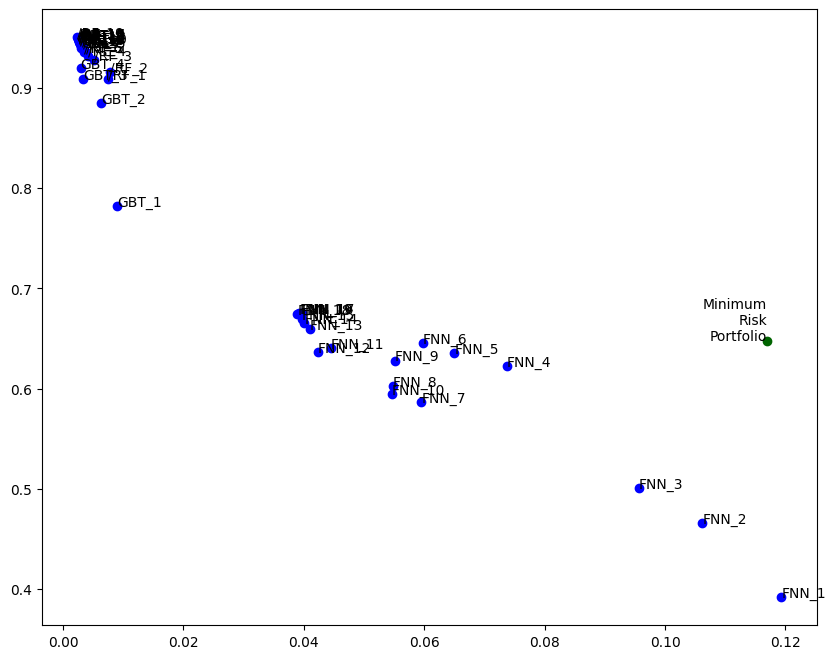

In [117]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))
print(frontier.shape)
print(frontier)
fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=mean_var, y=mean_acc,
           color='Blue', label='Individual Epochs')
for i, name in enumerate(names):
    ax.annotate(name, (mean_var[i], mean_acc[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0, frontier[0].max()*5, mean_acc.min()*1, mean_acc.max()*5])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()